# Introductie Deep Learning

Auteurs: Joost Vanstreels (joost.vanstreels@hu.nl), Tijmen Muller (tijmen.muller@hu.nl) en Peter van den Berg (peter.vandenberg@hu.nl).

In semester 4 van de opleiding _Artificial Intelligence_ staat het onderwerp _Deep Learning_ centraal. Bij _Deep Learning_ worden neurale netwerken gebruikt om patronen te herkennen in allerlei ongestructureerde data, zoals beeld, video, audio en tekst. In deze introductie gaan we meteen wat basisstappen doorlopen om een simpel neuraal netwerk te maken. We doen dit met behulp van het populaire framework PyTorch (https://pytorch.org/), dat we vaker zullen gebruiken in het semester.

## Inleiding

### Doel

Het doel van dit notebook is om een beeld te krijgen van de werking van neurale netwerken:

- Wat zijn neurale netwerken en hoe werken ze?
- Welke type problemen kun je oplossen met neurale netwerken?
- Wat is het verschil met andere machine learning technieken die zijn behandeld in S3, zoals decision trees en k-nearest neighbours?
- Wat is de toegevoegde waarde van _convolutionele_ neurale netwerken (CNNs)?

### Opzet

Aan de hand van theoretische uitleg en praktische voorbeelden gaan jullie zelfstandig aan de slag met enkele opdrachten:

1. We starten met het opzetten van een simpel neuraal netwerk dat jullie gaan aanpassen om betere resultaten te krijgen;
2. Daarna gaan jullie het neuraal netwerk uitbreiden met meerdere lagen;
3. Ook dit model gaan jullie verbeteren, op zoek naar een hoge nauwkeurigheid;
4. Tenslotte gaan we hetzelfde proberen te realiseren met k-NN.

### Voorbereiding

- Installeer de benodigde libraries (zie [`README.md`](./README.md)) en draai het notebook bij voorkeur lokaal. Mocht je het niet werkend krijgen, dan kun je uitwijken naar Google Colab.

### Werkwijze

- Lees de uitleg goed;
- Voer de code stap-voor-stap uit;
- Voer de opdrachten uit; cellen die getagd zijn met `student` moet je zelf invullen;
- Voor het uitvoeren van de opdrachten heb je geen externe bronnen nodig: alle benodigde kennis is gegeven in dit notebook;


## Deel I. Machine learning met neurale netwerken

### Herkennen van handgeschreven cijfers

We gaan aan de slag met de '*Hello, World!*' van neurale netwerken: het herkennen van de handgeschreven cijfers van de [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Deze dataset bestaat uit een trainset van 60.000 plaatjes met cijfers en een testset van nog eens 10.000 plaatjes.

De plaatjes zien er als volgt uit (bron: https://commons.wikimedia.org/wiki/File:MnistExamples.png):

![A few samples from the MNIST test dataset.](./img/MnistExamples.png "A few samples from the MNIST test dataset.")

### Benodigde libraries 

We hebben een aantal libraries nodig, sommigen kennen jullie al.

In [1]:
import random  
import time
import platform

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchmetrics.classification
import torchinfo

# Wetenschappelijke notitie uitzetten voor leesbaarheid
torch.set_printoptions(sci_mode=False)

In [2]:
# Controleer versie
print("Getest met: Python 3.12.12 en PyTorch 2.9.1+cu128")
print("Huidige installatie: Python", platform.python_version(), "en PyTorch", torch.__version__)

# Controleer en selecteer device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')  # Forceer cpu
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Getest met: Python 3.12.12 en PyTorch 2.9.1+cu128
Huidige installatie: Python 3.12.12 en PyTorch 2.9.1+cu128
Using device: cuda
NVIDIA GeForce RTX 4070 Laptop GPU


### Stap 1. Data exploration & data transformation

De MNIST dataset is gebundeld in PyTorch, we kunnen deze eenvoudig importeren.

In [3]:
dataset_original = datasets.MNIST(root='data/', train=True, download=True)
print(dataset_original[0])

(<PIL.Image.Image image mode=L size=28x28 at 0x2024B575AC0>, 5)


Als we kijken naar de inhoud van de dataset, dan zien we dat één datapunt bestaat uit een afbeelding in [PIL-formaat](https://pillow.readthedocs.io/en/stable/) op index 0 en een integer op index 1. Er zijn 60.000 datapunten in de trainset en 10.000 datapunten in de testset.

De integer is de klasse van het datapunt, dus welk getal het plaatje voorstelt: in geval van het eerste datapunt dus een '5'. De inhoud van de afbeelding kunnen we eenvoudig weergeven met PyPlot:

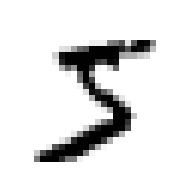

In [4]:
plt.figure(figsize=(2, 2))
plt.imshow(dataset_original[0][0], cmap='binary', interpolation='none')
plt.axis('off')
plt.tight_layout()

Een neuraal netwerk kan niet omgaan met deze ruwe data, maar heeft _matrices van getallen_ nodig als input. Gelukkig heeft PyTorch functionaliteit beschikbaar om deze conversie voor ons te doen in de vorm van [`ToTensor()`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor). Deze zet de afbeelding om in een Numpy array met de dimensies _kleurkanaal_ x _hoogte_ x _breedte_. We kunnen deze functie direct meegeven bij het importeren van de dataset, dus dat doen we hier opnieuw:

In [5]:
dataset_train = datasets.MNIST(root='data/', train=True, download=True, transform=ToTensor())
dataset_test = datasets.MNIST(root='data/', train=False, download=True, transform=ToTensor())

print("Train set:", len(dataset_train), "items")
print("Test set:", len(dataset_test), "items")

Train set: 60000 items
Test set: 10000 items


We zien nu dat de afbeelding op index 0 is vervangen door een tensor van 1 x 28 x 28. Het gaat dus om een plaatje van 28 bij 28 pixels, met in de eerste dimensie een kleurkanaal. Omdat we te maken hebben met grijstinten, is er hier maar sprake van één dimensie -- die kunnen we verwijderen zonder verlies van informatie. In het geval van een afbeelding met kleur zouden we drie (RGB) dimensies hebben op dit kanaal, dat zouden we niet zomaar mogen verwijderen!

Als we naar het datatype kijken, dan zien we dat het gaat om een `torch.Tensor`. Voor nu is het voldoende om te weten dat zo'n Tensor veel lijkt op een Numpy array, maar dat een tensor extra functionaliteit geeft die in het bijzonder belangrijk is voor _deep learning_.

**NB**. Als je kijkt naar de dataset dan zie je een groot verschil met de datasets die we gezien hebben bij het vorige semester, _Data Science_. Daar hadden we te maken met `.csv`-bestanden met datasets met meerdere kolommen en verschillende datatypes als inhoud. We konden kiezen welke features we als input gingen gebruiken. Met andere woorden: de inhoud van deze datasets was gestructureerd (als een tabel). De MNIST train dataset bestaat eigenlijk uit 60.000 keer 784 (28 x 28) pixelwaardes... dat is ongestructureerde data. Want er is dataschema over de betekenis van  pixels op een bepaalde rij of kolom.

In [6]:
print(dataset_train[0][0].shape, end='\n\n')
dataset_train[0]

torch.Size([1, 28, 28])



(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

We gaan de datasets omvormen tot een train en een test set met daarin de plaatjes en de klassen apart. We verwijderen daarbij direct het ééndimensionale kleurkanaal.

In [7]:
x_train = torch.zeros(size=(60000, 28, 28))
y_train = torch.zeros(size=(60000, 1))

for i, data in enumerate(dataset_train):
    # Verwijder kleurkanaal
    x_train[i] = data[0].reshape(28,28) 
    y_train[i] = data[1]
    
x_test = torch.zeros(size=(10000, 28, 28))
y_test = torch.zeros(size=(10000, 1))

for i, data in enumerate(dataset_test):
    # Verwijder kleurkanaal
    x_test[i] = data[0].reshape(28,28) 
    y_test[i] = data[1]


Met matplotlib kunnen we weer een aantal plaatjes uit de dataset bekijken, ook nu het matrices van getallen zijn geworden.

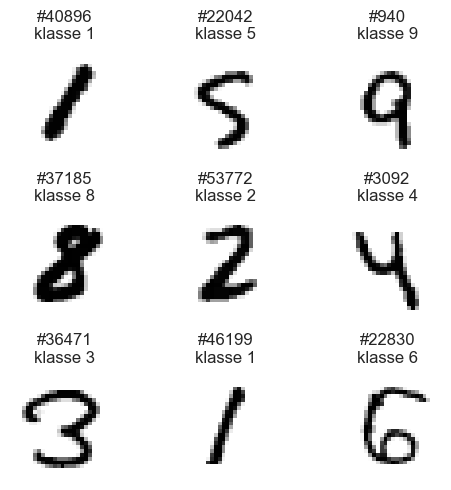

In [8]:
plt.figure(figsize=(5, 5))

for i in range(9):
    plt.subplot(3, 3, i+1)
    mnist_number = random.randint(0, len(dataset_train))
    plt.imshow(x_train[mnist_number], cmap='binary', interpolation='none')
    plt.title(f"#{mnist_number}\nklasse {int(y_train[mnist_number][0])}")
    plt.axis('off')
    
plt.tight_layout()

Een plaatje is nu dus eigenlijk niks meer dan een tweedimensionale array met 28 x 28 grijswaardes. Elke pixel is een float met waardes tussen 0 (zwart) en 1 (wit). Hieronder wordt complete matrix getoond van het getal rechtsonder in bovenstaande figuur:

In [9]:
def matprint(mat, fmt=".2g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print()

matprint(x_train[mnist_number])

0  0  0  0  0  0  0       0       0       0       0     0      0      0      0      0     0      0      0       0     0      0      0     0       0  0  0  0  
0  0  0  0  0  0  0       0       0       0       0     0      0      0      0      0     0      0      0       0     0      0      0     0       0  0  0  0  
0  0  0  0  0  0  0       0       0       0       0     0      0      0      0      0     0      0      0       0     0      0      0     0       0  0  0  0  
0  0  0  0  0  0  0       0       0       0       0     0      0      0      0      0     0      0      0       0     0      0      0     0       0  0  0  0  
0  0  0  0  0  0  0       0       0       0       0     0  0.047    0.5   0.67   0.78  0.51   0.35  0.059  0.0039     0      0      0     0       0  0  0  0  
0  0  0  0  0  0  0       0       0  0.0039    0.14   0.2   0.83      1   0.97   0.86  0.96   0.98      1    0.72   0.5   0.36  0.047     0       0  0  0  0  
0  0  0  0  0  0  0       0       0     0.3   

### Stap 2. Data preparation

#### Features

De input voor het neuraal netwerk is de matrix die het plaatje representeert. Dat plaatje bestaat eigenlijk uit 784 features, namelijk alle 784 pixels. Zo'n 28 x 28 matrix is niet handig als input voor een 'gewoon' neuraal netwerk. We moeten er een vector van maken door _flattening_ toe te passen (zie figuur hieronder). We vormen de 28 x 28 matrix dan om tot een vector met een lengte van 28 x 28 = 784 elementen.

NB. Het is ook belangrijk om de input te normaliseren. Dat is hier niet meer nodig, omdat de grijswaarden allemaal al netjes tussen 0 en 1 liggen door de eerder toegepaste transformatie.

![Flattening](./img/flattening.png "Flattening")

In [10]:
# Let op: we schakelen hier over van een kleine letter naar een hoofdletter, zodat de originele
# trainingsdata in `x_train` beschikbaar blijft!

# Reshape de 60.000 plaatjes van 28 x 28 matrices naar 60.000 784-lengte vectoren.
X_train = x_train.reshape(60000, 784)  
X_test = x_test.reshape(10000, 784)

print("Training matrix shape:", X_train.shape)
print("Testing matrix shape:", X_test.shape)

Training matrix shape: torch.Size([60000, 784])
Testing matrix shape: torch.Size([10000, 784])


#### Target

De target variabele is een 0, 1, 2, ... of 9. Dat zijn de verschillende klasses of categorieën. Kijk bijvoorbeeld maar eens naar de inhoud van een willekeurig item uit `y_train`:

Dit is een: 6


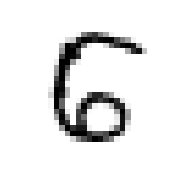

In [11]:
print("Dit is een:", int(y_train[mnist_number]))

plt.figure(figsize=(2,2))
plt.imshow(X_train[mnist_number].reshape(28,28), cmap='binary', interpolation='none')
plt.axis('off')
plt.show()

In het vorige Data Science semester hebben we altijd gewerkt met één targetvariabele die meerdere waardes kon krijgen. Denk aan classificeren waarbij je verschillende klasses kon voorspellen of regressie waarbij je meerdere waardes kon voorspellen.

In dit geval werkt het iets anders: we hebben meerdere targetvariabelen die allemaal corresponderen met één klasse. In dit geval hebben we 10 target variabelen die corresponderen met 0, 1, 2, ... of 9. 

We moeten de target aanpassen naar het onderstaande formaat. Deze transformatie noemen we _one hot encoding_.

- `0` wordt `[1, 0, 0, 0, 0, 0, 0, 0, 0`]
- `1` wordt `[0, 1, 0, 0, 0, 0, 0, 0, 0`]
- `2` wordt `[0, 0, 1, 0, 0, 0, 0, 0, 0]`
- et cetera

Het neuraal netwerk gaat straks proberen te voorspellen welk cijfer in een plaatje staat. Net zoals bij decision trees, k-NN, etc. zal een voorspelling niet altijd 100% zeker zijn. Het zal vaak een voorspelling zijn met een bepaalde betrouwbaarheid, bijvoorbeeld iets als dit:

`[0.94, 0, 0, 0, 0, 0, 0.06, 0, 0.07, 0.11]`

In dit geval is de voorspelling een '0' met een hoge zekerheid (want de waarde 0.94 op index `0` geeft een hoge kans), maar geeft het neurale netwerk ook een kleine kans aan een '6', een '8' en een '9'.

In [12]:
n_classes = 10  # Aantal klassen

Y_train = one_hot(y_train.long(), n_classes).squeeze().float()
Y_test = one_hot(y_test.long(), n_classes).squeeze().float()

print("De", y_train[mnist_number], "is na one hot encoding:", Y_train[mnist_number])

De tensor([6.]) is na one hot encoding: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])


We kunnen deze _one hot encoding_ weer eenvoudig terugvertalen naar het originele label (en dus het getal dat het plaatje voorstelt) met behulp van de `argmax()` functie. Deze functie geeft de _index_ terug van het maximum in een array:

In [13]:
print("Encoding", Y_train[mnist_number], "heeft het maximum op index", int(torch.argmax(Y_train[mnist_number])))

pred = torch.Tensor([0.94, 0, 0, 0, 0, 0, 0.06, 0, 0.07, 0.11])
print("\nVoorspelling", pred, "heeft het maximum op index", int(torch.argmax(pred)))


Encoding tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]) heeft het maximum op index 6

Voorspelling tensor([0.9400, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0600, 0.0000, 0.0700,
        0.1100]) heeft het maximum op index 0


### Stap 3. Modelling

#### Een eerste supersimpel netwerk
We gaan toewerken naar een _fully connected network_ met 3 _layers_ (lagen) plus een inputlaag zoals hieronder. Merk op dat je dit figuur van onder naar boven moet lezen: de input (het plaatje van 28 bij 28) staat onderaan, de output (met andere woorden, de voorspelde klasse) staat bovenaan.

![Compleet netwerk](./img/network_complex.png "Compleet netwerk")

Maar voordat we dat gaan doen, gaan we eerst een heel simpel netwerk maken dat maar uit één laag bestaat. De input voor het netwerk zijn de 784 pixels en de output zijn de 10 mogelijke klasses:

![Simpel netwerk](./img/network_simple.png "Simple netwerk")

#### Hoe werkt een neuraal netwerk?

Een voorspelling van een neuraal netwerk bestaat eigenlijk uit weinig meer dan heel veel berekeningen; dit noemen we de _feed forward_. Een netwerk bestaat uit *neuronen* en *verbindingen*. Voor alle 784 pixels zijn neuronen gemaakt die zijn gekoppeld aan alle 10 klassen in de outputlaag; ook hiervoor zijn neuronen gemaakt. Er zijn in totaal 784 x 10 = 7.840 verbindingen tussen alle neuronen van de inputlaag en de neuronen van de outputlaag. Daarbovenop zijn er nog 10 verbindingen met 10 biasneuronen.

Elke verbinding heeft een gewicht. De waarde van elke pixel is de waarde van de inputneuron, deze wordt vermenigvuldigd met het gewicht van een verbinding. Elk van de 10 outputneuronen heeft als input de som van alle vermenigvuldigingen. De klasse van de outputneuron waarvan de som het hoogste is, is de voorspelling!

#### Model opbouwen

Om een neuraal netwerk te definiëren in PyTorch, moeten we een klasse maken op basis van de `nn.Module` klasse:
- In de `__init__()` constructor definiëren we de lagen van ons netwerk; in het geval van ons simpele netwerk is dat één laag. Het type laag dat we hier gebruiken is `Linear`.
- In de `forward()` methode definiëren we _hoe_ de input data `x` stapsgewijs door de lagen gaat. In ons geval gaat het simpelweg door de ene laag; de uitvoer van deze laag `logits` heeft dus 10 elementen na de berekening die plaatsvindt in onze enige laag `fc1`.
- Tenslotte kiezen we een activatiefunctie, die een (niet-lineaire) berekening doet op de uitvoer van een laag. Het type activatiefunctie is hier `Sigmoid()`.

_Activatiefunties_ zijn berekeningen om iets slims te doen met de som van alle vermenigvuldigingen die als input binnen komen. Later zullen we zien waarom dat zo belangrijk is. In dit geval nemen we de _sigmoid function_ als activatiefunctie. Deze zorgt ervoor dat de output nooit lager dan -1 of hoger dan 1 wordt. Dit is een soort van normaliseren. Voor de volledigheid, de formule en de grafiek van de sigmoid zijn:

$$ a(z) = \frac{1}{1 + {\rm e}^{-Z}} $$

![Sigmoid](./img/sigmoid_function.png "Sigmoid")

**Opdracht**: kies het juiste aantal inputs `n_inputs` en outputs `n_outputs` voor de laag `fc1`.

In [14]:
# class SimpleNetwork(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.fc1 = nn.Linear(n_inputs, n_outputs)
#     self.fn_activate = nn.Sigmoid()
#
#   def forward(self, x):
#     # Pass data x door eerste laag
#     logits = self.fc1(x)
#
#     # Activatie met sigmoid
#     a = self.fn_activate(logits)
#
#     return a
#
#   def reset(self):
#     # Reset gewichten van het network
#     torch.nn.init.xavier_uniform_(self.fc1.weight)

In [15]:
class SimpleNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    # 28x28= 784 pixels is input
    # getallen van 0 t/m 9 zijn 10 mogelijke outputs
    self.fc1 = nn.Linear(784, 10)
    self.fn_activate = nn.Sigmoid()

  def forward(self, x):
    # Pass data x door eerste laag
    logits = self.fc1(x)

    # Activatie met sigmoid
    a = self.fn_activate(logits)

    return a

  def reset(self):
    # Reset gewichten van het network
    torch.nn.init.xavier_uniform_(self.fc1.weight)

We initialiseren tenslotte het model.

In [16]:
simple_model = SimpleNetwork()
simple_model

SimpleNetwork(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
  (fn_activate): Sigmoid()
)

Ons eerste, simpele model is nu helemaal opgebouwd. Met `torchinfo.summary()` kunnen we een samenvatting van het eindresultaat krijgen. Hieronder zie je het volgende, als je alles goed hebt gedaan:

```raw
=================================================================
Layer (type:depth-idx)                   Param #
=================================================================
SimpleNetwork                            --
├─Linear: 1-1                            7,850
├─Sigmoid: 1-2                           --
=================================================================
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
=================================================================
```

In [17]:
print(torchinfo.summary(simple_model))

Layer (type:depth-idx)                   Param #
SimpleNetwork                            --
├─Linear: 1-1                            7,850
├─Sigmoid: 1-2                           --
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0


#### Evaluatie (prelude)

Ons eerste supersimpele model is nu al gereed om te voorspellen, maar het is nog _niet_ getraind. Het model is geinitialiseerd met willekeurige waarden als parameters, dus we kunnen het gebruiken om te voorspellen, maar het zal zeer slecht presteren, want in feite gokt het maar wat. Hieronder een voorbeeld van een voorspelling (eigenlijk een gok dus) en de echte waarde. (Als ze overeenkomen, is dit puur toeval.)

In [18]:
prediction = simple_model(X_train[mnist_number])

print("De voorspelling per cijfer:", prediction)
print("Dit komt overeen met het voorspelde label:", torch.argmax(prediction))

print("\nDe echte waarde is:", Y_train[mnist_number])
print("Dit komt overeen met het echte label:", torch.argmax(Y_train[mnist_number]))

De voorspelling per cijfer: tensor([0.5623, 0.5825, 0.5128, 0.5365, 0.4631, 0.4034, 0.5130, 0.5239, 0.4900,
        0.4341], grad_fn=<SigmoidBackward0>)
Dit komt overeen met het voorspelde label: tensor(1)

De echte waarde is: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
Dit komt overeen met het echte label: tensor(6)


Door bovenstaande vergelijking tussen voorspelling en echte waarde uit te voeren op _alle_ waarden uit een dataset kunnen we een accuracy berekenen: welk deel van de (in dit geval train) dataset wordt goed voorspeld door het model? Nogmaals: we werken met willekeurige waarden, dus het resultaat moet een heel laag percentage zijn.

Voor het bepalen van de accuracy maken we gebruik van `torchmetrics`, die alle gebruikelijke evaluatiemetrieken voor ons kan bepalen. Laten we hier een functie `evaluate()` voor schrijven, die komt later vast nog van pas.

In [19]:
def evaluate(model, inputs, targets, device='cpu'):
    # print(f"Evaluating model on {device}")
    
    # Data op juiste device plaatsen
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Voorspel voor gehele dataset
    predictions = model(inputs)

    # Decodeer voorspellingen en targets
    predicted_labels = torch.argmax(predictions, dim=1)
    targets = torch.argmax(targets, dim=1)

    # Initialiseer accuracy berekening op voorspellingen en targets
    test_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=n_classes).to(device)
    test_accuracy.update(predicted_labels, targets)

    return test_accuracy.compute().cpu()

**Opdracht**: Beredeneer welke _accuracy_ je hier verwacht; met andere woorden: wat is de prestatie van je baseline model en waarom?

_Schrijf hier je antwoord._


Ik denk dat het 10% is omdat er 10 mogelijke outputs kunnen zijn is er 10% accuracy als die 1 bepaalde voorspelling doet en de dataset evenredig is verdeeld.

In [20]:
accuracy = evaluate(simple_model, X_train, Y_train)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 12.50%


### Training configureren

In semester 3 hebben we gezien dat een model allerlei hyperparameters kent, zoals de diepte van een beslisboom, de afstandsfunctie bij _k_-NN of het aantal clusters bij _k_-Means. Er zijn ook veel hyperparameters te kiezen bij het trainen van machine learning modellen, maar daar hebben we nog maar weinig aandacht aan geschonken in S3. De belangrijkste reden hiervoor is dat het optimalisatie-algoritme niet zo belangrijk is bij de modellen die we in S3 gebruikt hebben. Het trainen (of 'fitten') van het model met het standaardalgoritme lukte altijd goed en snel genoeg.

Bij neurale netwerken werkt het trainen van een model anders. Het is een stuk complexer waardoor er twee risico's zijn:
- Je vindt geen goede oplossing;
- Het vinden van een goede oplossing duurt lang.

Daarom moet je bij een neuraal netwerk goed nadenken over de **loss function** en de **optimizer** bij het trainen met behulp van **gradient descent**. Daarbij is ook de **learning rate** erg belangrijk.

#### Gradient descent

Gradient descent is het zoeken naar een minimum:

![Gradient descent](./img/gd.png "Gradient descent")

Je kunt dat minimum niet zien, dus je moet stapjes in de juiste richting nemen. De grootte van een stap is de learning rate. Kleine stapjes nemen duurt lang, maar te grote stappen is ook niet altijd goed:

![Effect of learning rates](./img/lr_effect.png "Effect of learning rates")

Kleine stapjes zijn niet altijd beter. Het risico bij kleine stapjes is dat je blijft hangen bij een lokaal minimum, terwijl er andere (lagere) minima bestaan. Het vinden van het globale minimum is de optimale situatie.

![Global and local minima](./img/local_minimum.png "Global and local minima")

Enfin, hier gaan we later mee aan de slag. Voor nu kiezen we de volgende configuraties voor de _loss functie_ en de _optimizer_:

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=simple_model.parameters(), lr=0.01)

### Het model trainen

Nu kunnen we eindelijk het model gaan trainen! Zoals gezegd, werkt dat anders dan bij de modellen uit semester 3. De gewichten van alle verbindingen moeten berekend worden. Dat doe je stap-voor-stap:

- Voor elk item uit de traindata:
  1. Bepaal de output van het neurale netwerk.
  2. Vergelijk de output met de echte waarde.
  3. Als de waarde goed is, ga je naar het volgende item.
  4. Als de waarde niet goed is, dan pas je de gewichten van de verbindingen aan die tot het verkeerde antwoord geleid hebben.

Dat zijn heel veel berekeningen... en dat kost dus ook heel veel tijd! Je gaat daarom bij neurale netwerken niet op zoek naar dé oplossing (als die al bestaat...), maar naar _een_ oplossing die goed genoeg is. Of naar de beste oplossing gegeven een bepaalde tijd (_runtime_).

Hieronder een functie voor de training loop voor één _epoch_, waarbij alle datapunten één keer worden meegenomen in het trainen van het netwerk.

In [22]:
def train(network, data_loader, optimizer, criterion, device='cpu'):
    """ Train network for one epoch. """
    train_loss = 0.

    # Loop over alle batches van de dataset
    for i_batch, (inputs, target) in enumerate(data_loader):
        # Zet het model in trainmodus
        network.train()

        # Elke data-instantie is een (input, label) paar
        # Naar juiste device verplaatsen
        inputs, target = inputs.to(device), target.to(device)

        # maak voorspellingen voor deze batch
        outputs = network(inputs)

        # Bereken de loss en de gradients
        loss = criterion(outputs, target)
        train_loss += loss

        # Backpropagation
        # Bereken gradient
        loss.backward()
        # Pas gewichten aan
        optimizer.step()
        # Zet gradients terug naar 0 voor volgende iteratie
        optimizer.zero_grad()

    # Bereken de loss per epoch en return
    epoch_loss = train_loss / len(data_loader)
    return epoch_loss.cpu()


#### Een epoch trainen

We kunnen het netwerk nu een epoch gaan trainen! Hiertoe maken we een `DataLoader` object, die onze data in _batches_ kan inladen. Een _batch_ is hierbij een 'pakketje' met datapunten, waarbij je de grootte (dus het aantal datapunten) kan instellen.

In [23]:
training_set = torch.utils.data.TensorDataset(X_train, Y_train)
training_loader = torch.utils.data.DataLoader(dataset=training_set, batch_size=512, shuffle=True)

Met de methode `to()` kunnen we het model naar een _device_ verplaatsen; dat is CUDA als je een geschikte GPU hebt en anders gewoon de CPU.

NB. De variabele `device` is helemaal aan het begin van dit notebook eenmalig geinitialiseerd.

In [24]:
simple_model = simple_model.to(device)
print(device)

cuda


Als we de functie `train()` nu één keer uitvoeren, dan krijgen we de _loss_ terug op de training set.

In [25]:
loss = train(simple_model, training_loader, optimizer, loss_fn, device)
loss

tensor(1.6645, grad_fn=<ToCopyBackward0>)

Met de functie die we eerder hebben geschreven, kunnen we ook de accuracy bepalen op de train set.

In [26]:
accuracy = evaluate(simple_model, X_train, Y_train, device=device)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 88.93%


Je ziet de **loss** en **accuracy**. De accuracy kennen jullie: dat is het percentage goed voorspelde cijfers. De loss is het resultaat van de _loss function_ (ook wel _cost function_ genaamd). Het is nog te vroeg om hier dieper op in te gaan, maar onthoud voor nu dat het een foutmaat is, dus we willen hier een zo klein mogelijk getal zien: in de perfecte wereld is de loss gelijk aan 0.

### Stap 4. Evalueren

Leuk, die accuracy op de traindata, maar veel belangrijker is natuurlijk de prestatie op de test data! We kijken weer naar de accuracy, maar ook naar de loss (alhoewel die minder interessant is op dit moment).

In [27]:
predictions_test = simple_model(X_test.to(device)).to('cpu')
loss = loss_fn(predictions_test, Y_test)

accuracy = evaluate(simple_model, X_test, Y_test, device=device)

print(f"Results on test set: loss = {loss:.4f}, accuracy = {accuracy*100:.1f}%")

Results on test set: loss = 1.5883, accuracy = 89.7%


De algemene evaluatie is belangrijk, maar het is ook goed om specifieke / individuele voorspellingen te bekijken. Hieronder zie je een visualisatie van correct en incorrect voorspelde cijfers:

In [28]:
predicted_classes = torch.argmax(simple_model(X_test.to(device)), dim=1)
predicted_classes = predicted_classes.to('cpu')
correct = (predicted_classes == y_test.squeeze())

correct_indices = torch.nonzero(predicted_classes == y_test.squeeze())
incorrect_indices = torch.nonzero(predicted_classes != y_test.squeeze())

print(f"{len(correct_indices)} correct voorspeld")
print(f"{len(incorrect_indices)} incorrect voorspeld")

8979 correct voorspeld
1021 incorrect voorspeld


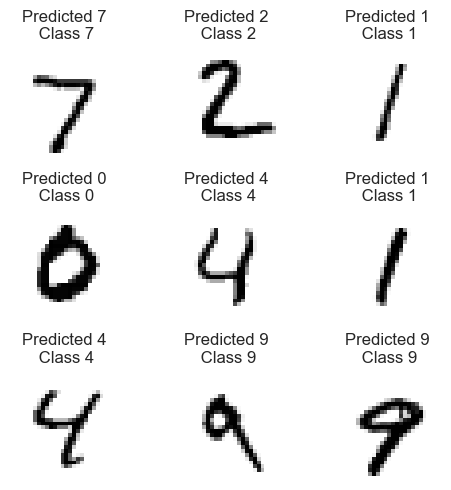

In [29]:
plt.figure(figsize=(5,5))
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[correct].reshape(28,28), cmap='binary', interpolation='none')
    plt.title(f"Predicted {int(predicted_classes[correct])}\n Class {int(y_test[correct])}")
    plt.axis('off')   
    
plt.tight_layout()

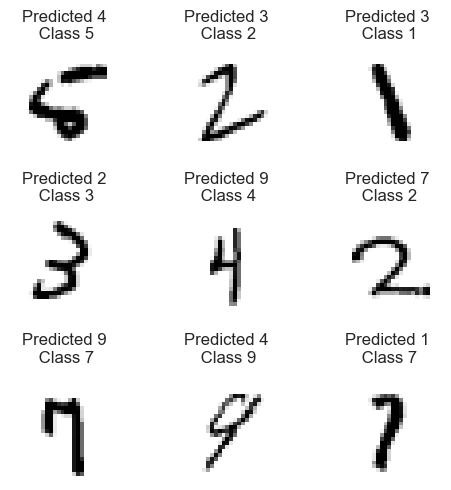

In [30]:
plt.figure(figsize=(5,5))
for i, correct in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='binary', interpolation='none')
    plt.title(f"Predicted {int(predicted_classes[correct])}\n Class {int(y_test[correct])}")
    plt.axis('off')   
    
plt.tight_layout()

### Opdracht 1. De accuracy verhogen

Een manier om te spelen met het trainen, is de keuze voor een **batch size**. Dit bepaalt hoeveel items uit de dataset per stap bekeken worden, voordat de gewichten geüpdatet worden. Grotere batch sizes zorgen voor nauwkeuriger trainen, de updates van de parameters zijn dan erg precies. Een kleine batch size (waarbij _online learning_ met batch size gelijk aan 1 de kleinste optie is) zorgt voor snelle updates (na elke batch een update), maar is minder nauwkeurig qua richting. Ook complexiteit speelt een rol bij het kiezen van batch size: een grotere batch gebruikt meer geheugen, maar is computationeel sneller. In de praktijk blijkt een grote batch size de neiging tot overfitting te hebben, maar de oorzaak hiervan is niet helemaal duidelijk. Het zoeken naar de beste batch size is vaak een kwestie van trial en error. Een goed startpunt is een batch size tussen de 32 en de 512 datapunten.

Daarnaast is het aantal **epochs** ook belangrijk. Dit geeft aan hoe vaak je de hele training set wilt gebruiken. Het is niet zo dat je na het bekijken van alle items uit de trainset klaar bent, je kunt de trainset nog een keer gebruiken om het model te verbeteren. En nog een keer. Enzovoorts. Zie het als het studeren voor een tentamen waarbij je een oefententamen vaker maakte om de stof te begrijpen.

**Opdracht.** Gebruik de code van een paar stappen terug en kijk of je de accuracy kunt verhogen. Dat kan op verschillende manieren.  
Kijk ook naar de benodigde tijd: duurt het trainen langer of korter?

Speel met:
- epochs
- batch size

**Merk op**: wanneer je meerdere keren achter elkaar de `train()` functie aanroept, train je het model steeds _verder_. Het is dus handig om na elk experiment het model te resetten om een eerlijke vergelijking te krijgen. Je kan hiervoor de `reset()` methode gebruiken: die overschrijft alle gewichten met willekeurig gekozen waarden en maakt het model dus effectief weer 'ongetraind'.

In [31]:
# TODO: Schrijf hier je code.


simple_model = SimpleNetwork()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=simple_model.parameters(), lr=0.01)

training_set = torch.utils.data.TensorDataset(X_train, Y_train)
training_loader = torch.utils.data.DataLoader(dataset=training_set, batch_size=64, shuffle=True)

simple_model = simple_model.to(device)

# herhalingen van zelfde trainingen
epochs = 10
for epoch in range(epochs):
    loss = train(simple_model, training_loader, optimizer, loss_fn, device)
    accuracy = evaluate(simple_model, X_train, Y_train, device=device)
    print(f"TRAIN(Epoch) {epoch+1}/{epochs}\nAccuracy: {accuracy * 100:.2f}% Loss:  {loss}")

predictions_test = simple_model(X_test.to(device)).to('cpu')
loss = loss_fn(predictions_test, Y_test)

accuracy = evaluate(simple_model, X_test, Y_test, device=device)

print(f"Results on test set: loss = {loss:.4f}, accuracy = {accuracy*100:.1f}%")

TRAIN(Epoch) 1/10
Accuracy: 90.56% Loss:  1.5931591987609863
TRAIN(Epoch) 2/10
Accuracy: 91.29% Loss:  1.55828857421875
TRAIN(Epoch) 3/10
Accuracy: 91.43% Loss:  1.5517271757125854
TRAIN(Epoch) 4/10
Accuracy: 91.25% Loss:  1.5479023456573486
TRAIN(Epoch) 5/10
Accuracy: 91.29% Loss:  1.5453274250030518
TRAIN(Epoch) 6/10
Accuracy: 91.81% Loss:  1.5433285236358643
TRAIN(Epoch) 7/10
Accuracy: 91.76% Loss:  1.541654348373413
TRAIN(Epoch) 8/10
Accuracy: 91.89% Loss:  1.5400017499923706
TRAIN(Epoch) 9/10
Accuracy: 92.25% Loss:  1.5391992330551147
TRAIN(Epoch) 10/10
Accuracy: 91.99% Loss:  1.5379873514175415
Results on test set: loss = 1.5409, accuracy = 91.9%


Geef hieronder aan welke accuracy je hebt behaald bij welk aantal epochs en welke batch size. Als je in de buurt bent van 92% accuracy op de testset, dan kun je door naar de volgende opdracht.

_Schrijf hier je antwoord._

Een accuracy van 91.8, epochs(herhaling training) van 10 en een batchsize van 64

### Opdracht 2. Modelling van een completer netwerk

#### Een fully connected 3-layer network

We gaan ons supersimpele netwerk nu uitbouwen tot een fully connected 3-layer network zoals hieronder:

![Compleet netwerk](./img/network_complex.png "Compleet netwerk")

#### Waarom meer lagen?!

Het idee is dat een netwerk met meerdere lagen, complexere taken kan uitvoeren. In theorie zou de accuracy voor de MNIST dataset hiermee verhoogd moeten kunnen worden.

### Opdracht 2.a. Het netwerk opbouwen

We moeten een nieuw netwerk klasse gaan bouwen, noem deze `ComplexNetwork` (zie de klassedefinitie van `SimpleNetwork` eerder in dit notebook als voorbeeld).

#### De eerste laag

In ons eerste model hadden we een input van 784 en output van 10. Nu is de input weer 784 maar de eerste laag is een  **hidden layer** van 512 neuronen.

- Voeg een `Lineair()` laag toe aan de constructor van `ComplexNetwork`. 
- Voer in de methode `ComplexNetwork.forward()` de data door deze laag en gebruik de `Sigmoid()` als activatiefunctie.

#### De tweede laag

- Voeg een tweede `Lineair()` laag toe aan de constructor van `ComplexNetwork` met wederom 512 neuronen. 
- Voer in de methode `ComplexNetwork.forward()` de data uit de eerste laag door deze tweede laag en gebruik de `Sigmoid()` opnieuw als activatiefunctie.

####  De output laag

De laatste laag heeft 10 elementen, namelijk de 10 klasses. 

- Voeg een laag van 10 neuronen toe aan het model.
- Voer in de methode `ComplexNetwork.forward()` de data ook door deze laag en activeer met de sigmoid.
- In plaats van de sigmoid is het beter om als laatste te activeren met softmax -- als verbetering mag je dit ook proberen.

In [32]:
class ComplexNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 512)
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 10)
    self.fn_activate = nn.Sigmoid()

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.fn_activate(self.fc1(x))
    x = self.fn_activate(self.fc2(x))
    x = self.fc3(x)
    return x

  
  def reset(self):
    for layer in [self.fc1, self.fc2, self.fc3]:
        nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            layer.bias.data.zero_()


In [33]:
# Laten we even kijken hoe dat eruit ziet
complex_model = ComplexNetwork()

print(complex_model)
torchinfo.summary(complex_model)

ComplexNetwork(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (fn_activate): Sigmoid()
)


Layer (type:depth-idx)                   Param #
ComplexNetwork                           --
├─Linear: 1-1                            401,920
├─Linear: 1-2                            262,656
├─Linear: 1-3                            5,130
├─Sigmoid: 1-4                           --
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0

Als het goed is, ziet de samenvatting van het model hierboven er als volgt uit:

```raw
=================================================================
Layer (type:depth-idx)                   Param #
=================================================================
ComplexNetwork                           --
├─Linear: 1-1                            401,920
├─Linear: 1-2                            262,656
├─Linear: 1-3                            5,130
├─Sigmoid: 1-4                           --
=================================================================
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
=================================================================
```

NB. Met deze twee extra lagen is het totaal aantal te trainen parameters dus bijna een factor 100 gegroeid: 7850 naar 669.706!

#### Training configureren

Gebruik dezelfde instellingen voor het configureren van de training

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=complex_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)

#### Trainen

Gebruik dezelfde code voor het trainen van het model.

In [35]:
# TODO: Schrijf hier je code.


device = "cuda" if torch.cuda.is_available() else "cpu"

model = ComplexNetwork().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)

training_set = torch.utils.data.TensorDataset(X_train, Y_train)
training_loader = torch.utils.data.DataLoader(dataset=training_set, batch_size=64, shuffle=True)

epochs = 10
for epoch in range(epochs):
    loss = train(model, training_loader, optimizer, loss_fn, device)
    accuracy = evaluate(model, X_train, Y_train, device=device)
    print(f"TRAIN(Epoch) {epoch+1}/{epochs}\nAccuracy: {accuracy * 100:.2f}% Loss:  {loss}")

# testset
predictions_test = model(X_test.to(device)).cpu()
loss = loss_fn(predictions_test, Y_test)

accuracy = evaluate(model, X_test, Y_test, device=device)
print(f"Results on test set: loss = {loss:.4f}, accuracy = {accuracy * 100:.1f}%")


TRAIN(Epoch) 1/10
Accuracy: 96.66% Loss:  0.28899717330932617
TRAIN(Epoch) 2/10
Accuracy: 97.88% Loss:  0.09399731457233429
TRAIN(Epoch) 3/10
Accuracy: 98.76% Loss:  0.05990522354841232
TRAIN(Epoch) 4/10
Accuracy: 99.11% Loss:  0.045021384954452515
TRAIN(Epoch) 5/10
Accuracy: 99.15% Loss:  0.030988045036792755
TRAIN(Epoch) 6/10
Accuracy: 98.95% Loss:  0.02676096186041832
TRAIN(Epoch) 7/10
Accuracy: 99.65% Loss:  0.023859191685914993
TRAIN(Epoch) 8/10
Accuracy: 99.51% Loss:  0.018670078366994858
TRAIN(Epoch) 9/10
Accuracy: 99.64% Loss:  0.016654467210173607
TRAIN(Epoch) 10/10
Accuracy: 99.54% Loss:  0.017118019983172417
Results on test set: loss = 0.0928, accuracy = 97.9%


### Opdracht 2.b.

Hoe goed heeft dit *uitgebreidere* netwerk het gedaan ten opzicht van ons 'supersimpele' netwerk? Als het goed is, al veel beter. Ga ook voor dit netwerk spelen met de epochs en batch size en kijk of je de accuracy kunt verhogen. Kijk ook weer naar de benodigde tijd: duurt het trainen langer of korter?

Speel ook met het aantal neuronen in de hidden layers, wat is het effect als je bijvoorbeeld maar 10 neuronen gebruikt in plaats van 512? Voeg eventueel ook hidden layers toe.

**Merk op:** vergeet niet om bij elk experiment het model te resetten.

Geef hieronder aan welke accuracy je hebt behaald bij welk aantal epochs en welke batch size. Geef ook de structuur van je netwerk aan, dus het aantal layers en het aantal neuronen per layer.  Als je in de buurt bent van 95% accuracy op de testset, dan kun je door naar de volgende opdracht. Als het goed is, kun je nu tot zo'n 98% komen. Als dat gelukt is, kun je verder gaan met de volgende opdracht.

_Schrijf hier je antwoord._

Mijn neural netwerk heb ik nie verandert qua structuur(784 > 512 > 512 > 10). Hij behaalt een accuracy van 98.1% bij epochs(herhaling training) van 10 en een batchsize van 64

## Deel II. Terug naar het verleden: MNIST met _k_-Nearest Neighbours

Zou het ook mogelijk zijn om cijfers te herkennen met de modellen die we geleerd hebben bij CM? Het is een classificatieprobleem dus regressie en clustering vallen af. Decision Trees zijn niet handig bij grote hoeveelheden features maar kNN kan prima over weg met veel features en in theorie zou je kNN kunnen gebruiken voor de MNIST dataset. Maar werkt het ook in de praktijk?

### Opdracht 3.a. _k_-NN voor MNIST

Duik het verleden in en trek _k_-NN van de plank om een classifier te maken voor de MNIST dataset.

In [36]:
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier    # kNN from sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Voer de volgende acties uit in de cellen hieronder:

- Gebruik `X_train` en `y_train` om een kNN classifier te fitten. 
- Leg een voorspelling voor `X_test` vast in `y_pred`. 
- Vergelijk deze met `y_test` en bereken de accuracy score.

In [45]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

val_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", val_accuracy)

C:\Users\moatr\miniconda3\envs\ai-s4\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.9688


### Resultaten analyseren

Maak een _confusion matrix_ `cm` door de voorspelde klassen te vergelijken met de werkelijke klassen.

In [43]:
# TODO: Schrijf hier je code.

cm = confusion_matrix(y_test, y_pred)

De cel hieronder visualiseert de confusion matrix `cm` voor meer inzicht.

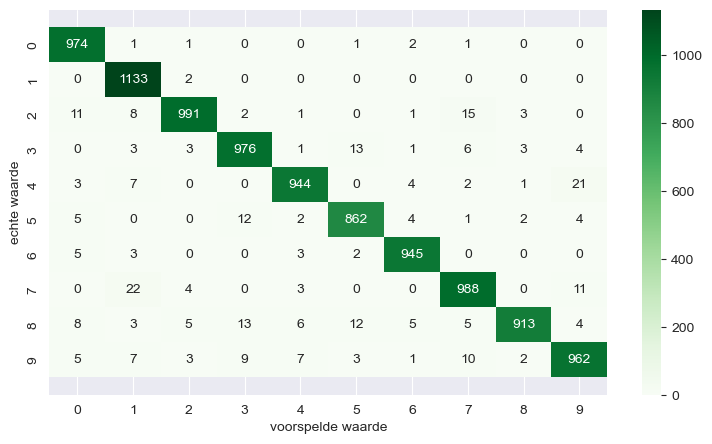

In [44]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=100)

ax = sns.heatmap(pd.DataFrame(cm), annot=True, cmap='Greens', fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.set_xlabel('voorspelde waarde')
ax.set_ylabel('echte waarde')

plt.show()

### Opdracht 3.b. Accuracy verhogen

Speel met de hyperparameters van kNN om de accuracy te verhogen.
Wat valt je op aan de accuracy van kNN t.o.v. het neuraal netwerk? En de performance van kNN t.o.v. het neuraal netwerk?

Geef hieronder de gevonden resultaten aan. Geef in ieder geval aan hoeveel _neighbors_ je hebt gebruikt, wat de afstandsfunctie was en hoe groot je train en je testset waren. Maak ook een vergelijking in performance tussen het neurale netwerk en _k_-NN.

Als het goed is, kun je nu tot zo'n 97% komen. Als dat gelukt is, ben je klaar.

_Schrijf hier je antwoord._

5 neighbours behaalde ik een accuracy van 0.9688

### Beperkingen van kNN

kNN doet het harstikke goed voor MNIST. Maar we hebben het hier over plaatjes van 28 x 28 pixels die eigenlijk zwart wit zijn. Wat als we complexere plaatjes zouden gebruiken? Of plaatjes van 1920x1080 pixels? De performance van kNN wordt dan dramatisch en de accuracy is dan ook bedroevend...


## Deel III. Fashion MNIST (extra)

De [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist/) lijkt op MNIST, maar de plaatjes zijn iets complexer. Kledingstukken lijken qua vorm meer op elkaar en er wordt gebruik gemaakt van meerdere grijstinten. 

![Fashion MNIST](./img/fashion_mnist.png "Fashion MNIST")

De accuracy van kNN duikt voor deze dataset al richting de 85%... niet best dus... en we hebben het hier nog steeds over superkleine plaatjes. Moet je na gaan wat er gebeurt bij grotere plaatjes.

Enfin, als je het leuk vindt om met de Fashion MNIST dataset aan de slag te gaan, gebruik dan onderstaande code om de dataset te importeren. Voor een goede analyse doorloop je uiteraard weer dezelfde processtappen.

In [46]:
fashion_train_data = datasets.FashionMNIST(root="./data", train=True, download=True, transform=ToTensor(), target_transform=None)
fashion_test_data = datasets.FashionMNIST(root="./data", train=False, download=True, transform=ToTensor(), target_transform=None)
fashion_classes = dict(enumerate(fashion_train_data.classes))

fashion_classes

100%|██████████| 26.4M/26.4M [00:00<00:00, 28.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.67MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 22.6MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 2.27MB/s]


{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

### Data exploration

In [ ]:
# TODO: Schrijf hier je code.

### Data transformation

In [ ]:
# TODO: Schrijf hier je code.

### Model creation

In [ ]:
# TODO: Schrijf hier je code.

### Model training

In [ ]:
# TODO: Schrijf hier je code.

In [ ]:
# TODO: Schrijf hier je code.

### Evaluation

In [ ]:
# TODO: Schrijf hier je code.

## Conclusies

Hopelijk heb je door deze workshop een beter beeld van wat neurale netwerken zijn en hoe ze werken en hebben we jullie gemotiveerd voor S4 van AI: _Deep Learning_!

## Deel IV. Deep learning met convolutionele neurale netwerken (CNNs)

### Beperkingen van neurale netwerken

De gevonden resultaten zijn bemoedigend, maar neurale netwerken hebben hun beperkingen. Bekijk onderstaande geaugmenteerde varianties van de originele getallen uit de dataset:

<img src="img/augmented_mnist.png" />

Het is telkens hetzelfde getal, maar dan:
- Gedraaid
- Verkleind
- Verplaatst
- Scheefgetrokken

Laten we deze dataset eerst eens genereren!

### Benodigde libraries 

Er zijn wat nieuwe imports nodig. Eentje voor het maken van de dataset, en eentje om transformaties op data toe te kunnen passen.

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms

In [ ]:
# We creëren hier een Dataset klasse AugmentedMNIST. Deze ontvangt de originele mnist dataset.

class AugmentedMNIST(Dataset):
    def __init__(self, mnist):
        self.mnist = mnist
        
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, idx):
        image, label = self.mnist[idx]        
        image = transforms.ToPILImage()(image)
        
        augmentation = transforms.Compose([
            transforms.RandomAffine(        #We transformeren random...
                degrees=90,                 #Tot 90 graden rotatie
                scale=(0.4, 1.0),           #Tot 40% verkleining
                translate=(0.2, 0.2),       #Tot 20% verplaatsing
                shear=25                    #Tot 25 graden scheeftrekken
            ),
        ])
        
        image = augmentation(image)
        image = transforms.ToTensor()(image)
        image = transforms.Normalize((0.5,), (0.5,))(image)
        
        return image, label

augmented_train = AugmentedMNIST(dataset_train)
augmented_test = AugmentedMNIST(dataset_test)

#We herhalen de stappen van voorheen voor het prepareren van de datasets

x_train = torch.zeros(size=(60000, 28, 28))
y_train = torch.zeros(size=(60000, 1))

for i, data in enumerate(augmented_train):
    # Verwijder kleurkanaal
    x_train[i] = data[0].reshape(28,28) 
    y_train[i] = data[1]
    
x_test = torch.zeros(size=(10000, 28, 28))
y_test = torch.zeros(size=(10000, 1))

for i, data in enumerate(augmented_test):
    # Verwijder kleurkanaal
    x_test[i] = data[0].reshape(28,28) 
    y_test[i] = data[1]

X_train = x_train.reshape(60000, 784)  
X_test = x_test.reshape(10000, 784)

n_classes = 10  # Aantal klassen

Y_train = one_hot(y_train.long(), n_classes).squeeze().float()
Y_test = one_hot(y_test.long(), n_classes).squeeze().float()


In [ ]:
#En we creëren, trainen en evalueren het (complexe) lineaire model.
batch_size = 512 # Voor dit probleem werkt een batch size van 512 beter
linear_model = ComplexNetwork()
linear_model.to(device)

# Definieer training loader
training_set = torch.utils.data.TensorDataset(X_train, Y_train)
training_loader = torch.utils.data.DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=linear_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)

print(f"\nStarting training with batch size {batch_size}.")
loss_history, accuracy_history = list(), list()
time_start = time.time()

for epoch in range(20):
    loss = train(linear_model, training_loader, optimizer, loss_fn, device)
    accuracy = evaluate(linear_model, X_test, Y_test, device=device)
    
    loss_history.append(float(loss))
    accuracy_history.append(float(accuracy))
    time_lap = time.time()
    print(f"Epoch {epoch}: loss = {loss:.3f}; accuracy = {accuracy:.2f}, time: {time_lap - time_start:.1f}s")

plt.plot(accuracy_history, label=f"batch size {batch_size}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Test set accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

Zoals je ziet gaat zelf ons relatief complexe neurale netwerk de mist in bij deze dataset. Het model is te rigide en kan de grote variëteit van plaatjes in de dataset niet aan.

In [ ]:
predicted_classes = torch.argmax(linear_model(X_test.to(device)), dim=1)
predicted_classes = predicted_classes.to('cpu')

incorrect_indices = torch.nonzero(predicted_classes != y_test.squeeze())

plt.figure(figsize=(5,5))
for i, correct in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='binary', interpolation='none')
    plt.title(f"Predicted {int(predicted_classes[correct])}\n Class {int(y_test[correct])}")
    plt.axis('off')   
    
plt.tight_layout()

### Oplossing: kijken zoals mensen kijken

Wanneer wij een plaatje zien, gaan wij niet naar alle pixels kijken en daarmee bepalen of een plaatje een 3 is of iets anders. Wij kijken naar bepaalde patronen, vormen en/of structuren, bijvoorbeeld de drie *pootjes* die een drie heeft of de twee *rondjes* die een acht vormen. We kijken naar scheidingen tussen objecten op een foto of zaken die op de voorgrond of achtergrond staan. Op die manier maken wij onze *voorspellingen*. En dat is precies wat convolutionele neurale netwerken doen.

Voor de rest deel IV gaan we een convolutioneel netwerk toepassen op deze geaugmenteerde MNIST dataset! Heb je geen GPU ter beschikking, doe dan even samen met een student die dit wel heeft (anders duurt het te lang).

**Opdracht 1 - eenvoudig convolutioneel netwerk**

Vind voor alle parameters in onderstaande ConvNetwork die op 0 staan de waarden zodanig dat je het model kunt runnen zonder fouten én de prestatie hoger wordt dan 80%.  

In [ ]:
class ConvNetwork(nn.Module):
    def __init__(self):
        super(ConvNetwork, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(                              # We beginnen met een convolutielaag
                in_channels=0,                      # Hoeveel inputkanalen heeft de convolutionele laag?
                out_channels=0,                     # Met hoeveel outputkanalen kan een prestatie van minimaal 80% behaald worden?
                kernel_size=0,                      # Met welke kernelgrootte kan een prestatie van minimaal 80% behaald worden?
                padding=0                           # Met welke padding kan een prestatie van minimaal 80% behaald worden?
            ),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=0, stride=0),  # Met welke kernel_size en stride kan een prestatie van minimaal 80% behaald worden?
            
            # We eindigen met dezelfde lineaire lagen als in ons complexe lineaire model (maar wel met ReLu ipv Sigmoid)
            nn.Flatten(),            
            nn.Linear(0, 512),                      # Hoe groot is de vector die we uit de MaxPool2d laag krijgen?
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        return self.model(x)

### Train/evaluatie functies

In [ ]:
def evaluate(model, data_loader, device='cpu'):
    model.eval()
    correct = 0
    total = 0
    for inputs, targets in data_loader:  # Loop in batches door de loader        
        # Data op juiste device plaatsen
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Voorspel voor gehele dataset
        predictions = model(inputs)

        # Decodeer voorspellingen
        predicted = torch.argmax(predictions, dim=1)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    return correct / total

In [ ]:
def train_eval(model, epochs = 20):
    # Definieer training loader
    training_loader = DataLoader(augmented_train, batch_size=128, shuffle=True, num_workers=0)
    # Omdat nu ook het evalueren op de testset veel geheugen gaat vragen, breken we deze ook op in batches
    testing_loader = DataLoader(augmented_test, batch_size=128, shuffle=False, num_workers=0)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)
    model.to(device)

    loss_history, accuracy_history = list(), list()
    time_start = time.time()
    for epoch in range(epochs):
        loss = train(model, training_loader, optimizer, loss_fn, device)
        accuracy = evaluate(model, testing_loader, device=device)
        loss_history.append(float(loss))
        accuracy_history.append(float(accuracy))

        time_lap = time.time()
        print(f"Epoch {epoch}: loss = {loss:.3f}; accuracy = {accuracy:.2f}, time: {time_lap - time_start:.1f}s")

    plt.plot(accuracy_history)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Test set accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
#En we creëren, trainen en evalueren het convolutionele model.
# (Zet het aantal epochs omlaag als je nog niet zeker weet of je de juiste settings hebt. Op 5 bijvoorbeeld.)
conv_model = ConvNetwork()
train_eval(conv_model)

### Geleerde convoluties

Zoals je ziet, presteert dit convolutionele neurale netwerk al een stuk beter dan ons lineare netwerk. Je weet ondertussen hoe neurale netwerken werken én je weet hoe convoluties werken. Tijd om deze twee concepten samen te voegen! De kernels in bovenstaande convolutionaire laag zijn niet van te voren gedefinieerd. Het mooie aan een kernel is dat dit ook gewoon een matrix met gewichten is. Net als bij de gewichten van de lineaire lagen, initieren we de gewichten van de willekeurig. Met behulp van backpropagation leert het model zelf welke convoluties geleerd moeten worden.

Hieronder zie je de eerste acht kernels die zijn geleerd in deze eerste laag.

In [ ]:
conv_layer = conv_model.model[0]
kernels = conv_layer.weight.data.cpu()

fig, axes = plt.subplots(1, 8, figsize=(16, 2))

vmin = kernels[:8, 0].min()
vmax = kernels[:8, 0].max()

for i in range(8):
    ax = axes[i]
    kernel = kernels[i, 0]
    
    im = ax.imshow(kernel, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(f'Kernel {i}', fontsize=10)
    ax.axis('off')

fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle('Eerste 8 geleerde kernels', fontsize=14)
plt.tight_layout(rect=[0, 0, 0.92, 0.96])
plt.show()

Zoals je ziet ziet elke kernel er anders uit. Elke kernel herkent dus andere eigenschappen van de plaatjes. Dit is het gevolg van twee dingen:
- Random initialisatie - elke kernel begint met willekeurige, end dus unieke, waarden.
- Backpropagation - doordat het herkennen van verschillende eigenschappen zorgt voor betere resultaten, stuurt backpropagation daar automatisch naartoe.

Laten we nu eens kijken hoe het resultaat van deze convolutielaag eruit ziet.

In [ ]:
image_idx = 1
image = x_train[image_idx:image_idx+1].unsqueeze(1).to(device)  # [1, 1, 28, 28]

conv_model.eval()
with torch.no_grad():
    conv1_out = conv_model.model[0](image)  # Conv2d
    relu1_out = conv_model.model[1](conv1_out)  # ReLU
    pool1_out = conv_model.model[2](relu1_out)  # MaxPool2d

plt.figure(figsize=(20, 5))
for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(conv1_out[0, i].cpu(), cmap='viridis')
    plt.title(f'Conv {i}')
    plt.axis('off')


Je ziet dat de verschillende kernels andere resultaten tot gevolg hebben. De ene kernel activeert bijvoorbeeld vertical lijnen, en de andere horizontale. De resultaten van deze convoluties worden hierna door de ReLu activatiefunctie gehaald. Laten we eens kijken wat er met de plaatjes gebeurt als we deze door de ReLu-functie halen:

In [ ]:
plt.figure(figsize=(20, 5))
for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(relu1_out[0, i].cpu(), cmap='viridis')
    plt.title(f'Relu {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Zoals je ziet maakt de ReLufunctie nog duidelijker wat de kernels herkennen. Alle negatieve resultaten worden weggefiltert, waardoor alleen de patronen overblijven die door de kernels gevonden zijn. De laatste stap is de maxpoollaag. Laten we de output daarvan ook eens bekijken:

In [ ]:
plt.figure(figsize=(20, 5))
for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(pool1_out[0, i].cpu(), cmap='viridis')
    plt.title(f'Maxpool {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

De plaatjes zijn kleiner, maar toch lijkt het alsof er weinig informatie is weggegooid. Sterker nog: de gevonden patronen komen nog sterker naar voren!

**Opdracht 2 - Complex convolutioneel neuraal netwerk**

Het is interessant om te zien dat ons eenvoudige neurale netwerk al een prestatie behaald van 80%, maaar dat kan vast beter! Laten we ons netwerk uitbreiden. Ga zelf op zoek naar een netwerk dat zowel relatief efficient als effectief is. Zorg voor een prestatie van minimaal 90%. Waar zit de balans? Heeft het toevoegen van dropout layers nut?

In [ ]:
class ComplexConvNetwork(nn.Module):
    def __init__(self):
        super(ComplexConvNetwork, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(                              # We beginnen met een convolutielaag
                in_channels=0,                      # Hoeveel inputkanalen heeft de convolutionele laag?
                out_channels=0,                     # Met hoeveel outputkanalen kan een prestatie van minimaal 80% behaald worden?
                kernel_size=0,                      # Met welke kernelgrootte kan een prestatie van minimaal 80% behaald worden?
                padding=0                           # Met welke padding kan een prestatie van minimaal 80% behaald worden?
            ),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=0, stride=0),  # Met welke kernel_size en stride kan een prestatie van minimaal 80% behaald worden?

            # Welke lagen moeten worden toegevoegd om minimaal 90% te behalen?
            
            # We eindigen met dezelfde lineaire lagen als in ons complexe lineaire model (maar wel met ReLu ipv Sigmoid)
            nn.Flatten(),            
            nn.Linear(0, 512),                      # Hoe groot is de vector die we uit de MaxPool2d laag krijgen?
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        return self.model(x)

In [ ]:
#En we creëren, trainen en evalueren het (complexe) convolutionele model.
# (Zet het aantal epochs omlaag als je nog niet zeker weet of je de juiste settings hebt. Op 5 bijvoorbeeld.)

complex_conv_model = ComplexConvNetwork()
train_eval(complex_conv_model)

## Bronnen

- Khan, Muhammad Asad Iqbal. (2023, May 3). _Activation Functions in PyTorch._ https://machinelearningmastery.com/activation-functions-in-pytorch/

- Snelgrove, Xavier. (2016, January 27). _Building a simple neural-network with Keras._ https://github.com/wxs/keras-mnist-tutorial

- Chejara, Amit Subhash. (2025, Apr 10). _How I Hit 99.26% Accuracy on MNIST with a CNN in PyTorch._ https://medium.com/data-science-collective/implementing-cnn-in-pytorch-testing-on-mnist-99-26-test-accuracy-5c63876c6ac8

- Subramanian, S., Juarez, S., Breviu, C., Soshnikov, D., & Bornstein, A. (2025, Jul 7). _PyTorch: Learn the Basics._ https://docs.pytorch.org/tutorials/beginner/basics/intro.html